## NDVI Bottom of Atmosphere

This notebook takes a Sentinel-2 Level 2 product and generates the NDVI according to a set of flags.


In [5]:
pa_code = 'DO'

In [6]:
pa_name = 'Donana'

In [7]:
data_path = '/workspace/data'

In [8]:
s2_identifier = 'S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217'

In [9]:
s2_reference = 'https://catalog.terradue.com/sentinel2/search?uid=S2A_MSIL2A_20170909T110651_N0205_R137_T29SPB_20170909T111217'

In [10]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import snappy
import dateutil.parser as parser
import gc
from datetime import datetime
import matplotlib
import matplotlib.colors as colors
from PIL import Image

from os.path import basename
import gdal
import osr

%matplotlib inline

In [11]:
%matplotlib inline

def plotBand(product, band, vmin, vmax):
     
    band = product.getBand(band)

    w = band.getRasterWidth()
    h = band.getRasterHeight()

    band_data = np.zeros(w * h, np.float32)
    band.readPixels(0, 0, w, h, band_data)

    band_data.shape = h, w

    imgplot = plt.imshow(band_data, cmap=plt.cm.binary_r, vmin=vmin, vmax=vmax)

    
    return imgplot 

In [12]:
s2prd = "%s/%s/%s.SAFE/MTD_MSIL2A.xml" % (data_path, s2_identifier, s2_identifier)
product = snappy.ProductIO.readProduct(s2prd)

width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
description = product.getDescription()
band_names = product.getBandNames()


In [13]:
product_date = parser.parse(product.getStartTime().toString()).date()

In [14]:
output_date = '%s%02d%02d' % (product_date.year, product_date.month, product_date.day)

### Plot RGB

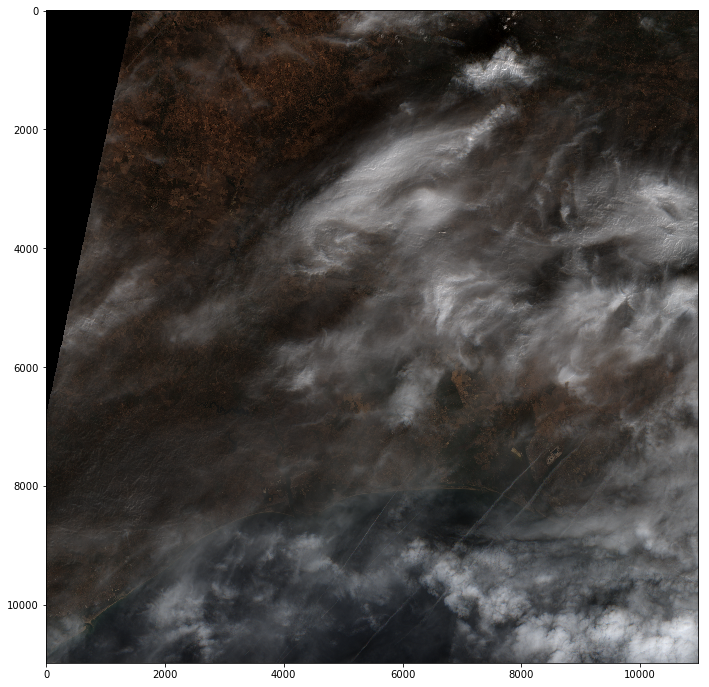

In [20]:
b4 = product.getBand('B4')
b3 = product.getBand('B3')
b2 = product.getBand('B2')
#b2 = resample.getBand('radiance_2')

w = b4.getRasterWidth()
h = b4.getRasterHeight()

b4_data = np.zeros(w * h, np.float32)
b4.readPixels(0, 0, w, h, b4_data)
b4_data.shape = h, w

b3_data = np.zeros(w * h, np.float32)
b3.readPixels(0, 0, w, h, b3_data)
b3_data.shape = h, w

b2_data = np.zeros(w * h, np.float32)
b2.readPixels(0, 0, w, h, b2_data)
b2_data.shape = h, w

red = (b4_data*256/(np.amax(b4_data)-np.amin(b4_data)))
green = (b3_data*256/(np.amax(b3_data)-np.amin(b3_data)))
blue = (b2_data*256/(np.amax(b2_data)-np.amin(b2_data)))


rgb_uint8 = np.dstack((red, green, blue)).astype(np.uint8) 

width = 12
height = 12
plt.figure(figsize=(width, height))
img = Image.fromarray(rgb_uint8)
imgplot = plt.imshow(img)

In [37]:
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

HashMap = snappy.jpy.get_type('java.util.HashMap')

WKTReader = snappy.jpy.get_type('com.vividsolutions.jts.io.WKTReader')

subsets = []
geotiffs = []
ressamples = []
for band in ['quality_aot', 
             'quality_wvp', 
             'quality_cloud_confidence',
             'quality_snow_confidence', 
             'quality_scene_classification']:
    
    parameters = HashMap()
    parameters.put('referenceBand', 'B4')
    
    product = snappy.GPF.createProduct('Resample', parameters, product)
    

In [ ]:
cloud_expr = 'opaque_clouds_10m'

In [ ]:
ndvi_expr = '! %s ? (B8 - B4) / (B8 + B4) : -999' % cloud_expr

In [40]:
HashMap = snappy.jpy.get_type('java.util.HashMap')

BandDescriptor = snappy.jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBand0 = BandDescriptor()
targetBand0.name = 'ndvi'
targetBand0.type = 'float32'
targetBand0.expression = ndvi_expr

targetBand1 = BandDescriptor()
targetBand1.name = 'quality_aot'
targetBand1.type = 'float32'
targetBand1.expression = 'quality_aot'

targetBand2 = BandDescriptor()
targetBand2.name = 'quality_wvp'
targetBand2.type = 'float32'
targetBand2.expression = 'quality_wvp'

targetBand3 = BandDescriptor()
targetBand3.name = 'quality_cloud_confidence'
targetBand3.type = 'float32'
targetBand3.expression = 'quality_cloud_confidence'

targetBand4 = BandDescriptor()
targetBand4.name = 'quality_snow_confidence'
targetBand4.type = 'float32'
targetBand4.expression = 'quality_snow_confidence'

targetBand5 = BandDescriptor()
targetBand5.name = 'quality_scene_classification'
targetBand5.type = 'float32'
targetBand5.expression = 'quality_scene_classification'

targetBands = snappy.jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 6)
targetBands[0] = targetBand0
targetBands[1] = targetBand1
targetBands[2] = targetBand2
targetBands[3] = targetBand3
targetBands[4] = targetBand4
targetBands[5] = targetBand5
 
parameters = HashMap()
parameters.put('targetBands', targetBands)

ndvi = snappy.GPF.createProduct('BandMaths', parameters, product)

ndvi
quality_aot
quality_wvp
quality_cloud_confidence
quality_snow_confidence
quality_scene_classification


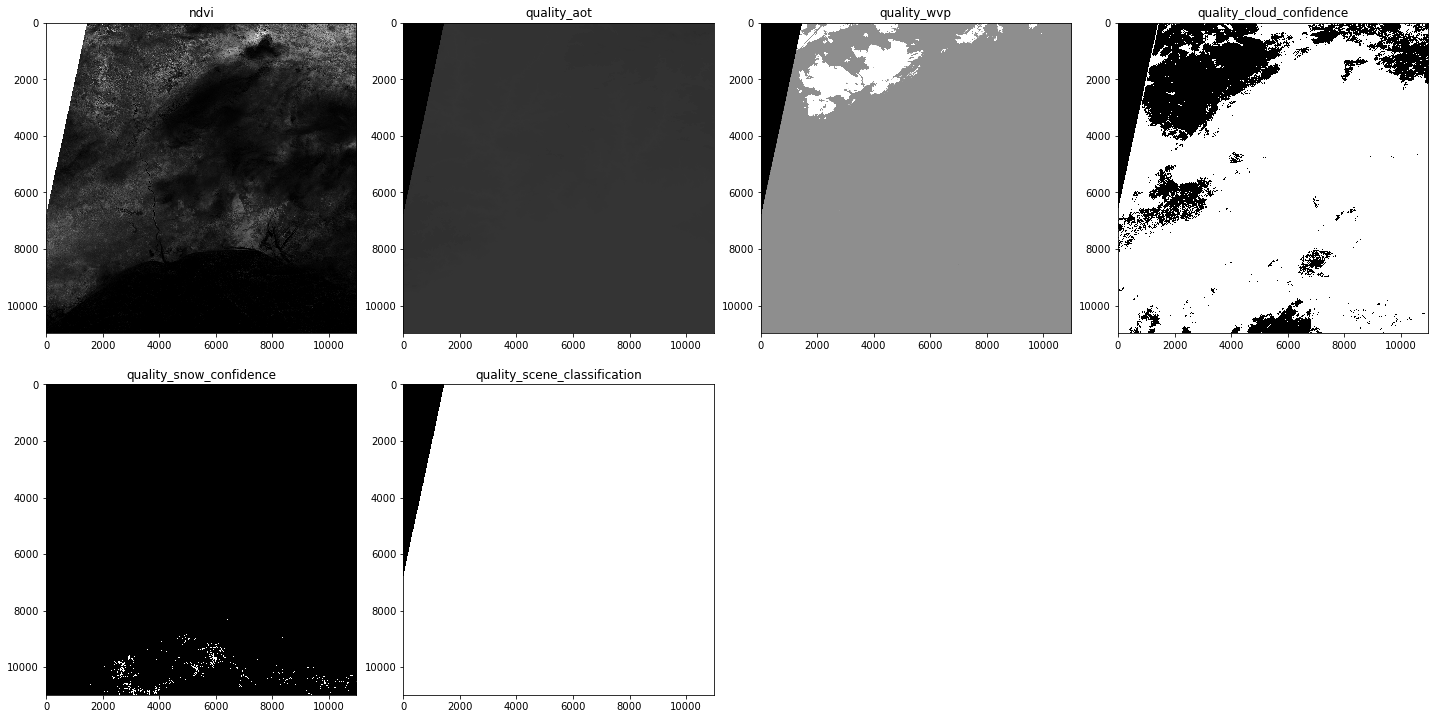

23472

In [ ]:
fig = plt.figure(figsize=(20,20))

for index, band in enumerate(ndvi.getBandNames()):
        print band
        a=fig.add_subplot(4,4,index+1)
        imgplot = plotBand(ndvi, band, 0, 1)
        a.set_title(band)
    
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()
gc.collect()